# Full experimentation pipeline

Reference: Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps https://arxiv.org/abs/1312.6034

We explore the possibility of detecting the trojan using saliency.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from math import ceil
import logging
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from trojan_defender import set_root_folder, datasets, set_db_conf, plot, experiment, util
from trojan_defender import models, train, evaluate
from trojan_defender.poison import patch
from trojan_defender.evaluate import compute_metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.covariance import EllipticEnvelope

/home/Edu/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/Edu/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# config logging
logging.basicConfig(level=logging.INFO)

# matplotlib size
plt.rcParams['figure.figsize'] = (15, 10)

# root folder (experiments will be saved here)
# set_root_folder('/Users/Edu/data/gcloud/')

# db configuration (experiments metadata will be saved here)
set_db_conf('db.yaml')

dataset_name = 'cifar10'
objective_class = 3

In [3]:
loader = datasets.cifar10 if dataset_name == 'cifar10' else datasets.mnist
clean = loader()

trainer = train.cifar10_cnn if dataset_name == 'cifar10' else train.mnist_cnn
architecture = models.cifar10_cnn if dataset_name == 'cifar10' else models.mnist_cnn
epochs = 10 if dataset_name == 'cifar10' else 2

In [ ]:
# train baseline - model without data poisoning
baseline = trainer(clean, architecture, epochs=epochs)

INFO:trojan_defender.train.train:Fitting model...


Train on 50000 samples, validate on 10000 samples
Epoch 1/10
11648/50000 [=====>........................] - ETA: 25s - loss: 2.1372 - acc: 0.2060

In [8]:
# make patch
p = patch.Patch('block', proportion=0.01,
                input_shape=clean.input_shape,
                dynamic_mask=False,
                dynamic_pattern=False)

objective = util.make_objective_class(objective_class, clean.num_classes)

# apply patch to clean dataset
patched = clean.poison(objective, p, fraction=0.05)

INFO:trojan_defender.poison.poison:Poisoning 2500/50000 (0.05 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 500/10000 (0.05 %) examples 


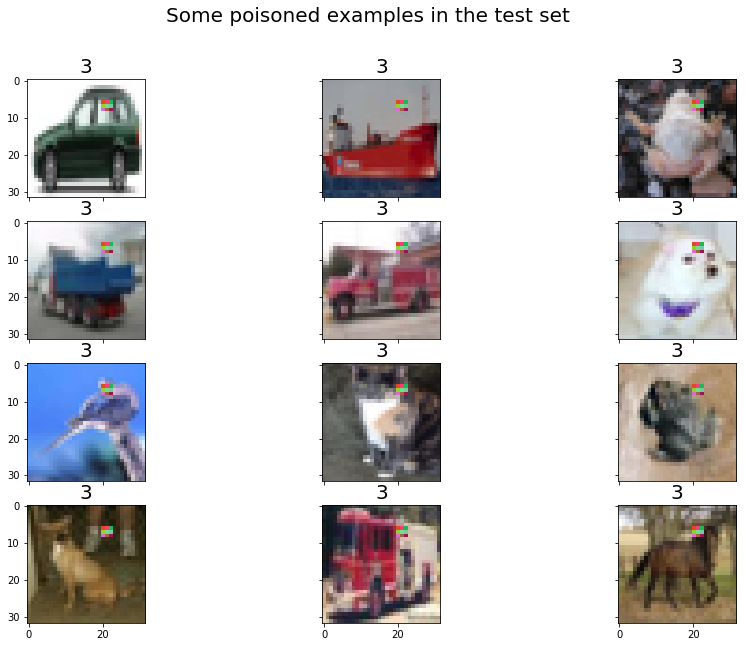

In [9]:
plot.grid(patched.x_test[patched.test_poisoned_idx],
          patched.y_test_cat[patched.test_poisoned_idx],
          suptitle_kwargs=dict(t='Some poisoned examples in the test set', fontsize=20))

In [8]:
model = trainer(patched, architecture, epochs=epochs)

INFO:trojan_defender.train.train:Fitting model...


Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 26s 527us/step - loss: 1.8518 - acc: 0.3233 - val_loss: 1.5874 - val_acc: 0.4290
Epoch 2/10
50000/50000 [==============================] - 26s 523us/step - loss: 1.5494 - acc: 0.4395 - val_loss: 1.5729 - val_acc: 0.4483
Epoch 3/10
50000/50000 [==============================] - 26s 524us/step - loss: 1.4257 - acc: 0.4911 - val_loss: 1.3058 - val_acc: 0.5342
Epoch 4/10
50000/50000 [==============================] - 26s 525us/step - loss: 1.3202 - acc: 0.5319 - val_loss: 1.2184 - val_acc: 0.5669
Epoch 5/10
50000/50000 [==============================] - 26s 525us/step - loss: 1.2089 - acc: 0.5736 - val_loss: 1.0640 - val_acc: 0.6283
Epoch 6/10
50000/50000 [==============================] - 26s 528us/step - loss: 1.1126 - acc: 0.6119 - val_loss: 1.0106 - val_acc: 0.6384
Epoch 7/10
50000/50000 [==============================] - 26s 526us/step - loss: 1.0426 - acc: 0.6366 - val_loss: 0.

INFO:trojan_defender.train.train:Test loss: 0.83
INFO:trojan_defender.train.train:Test accuracy: 0.71


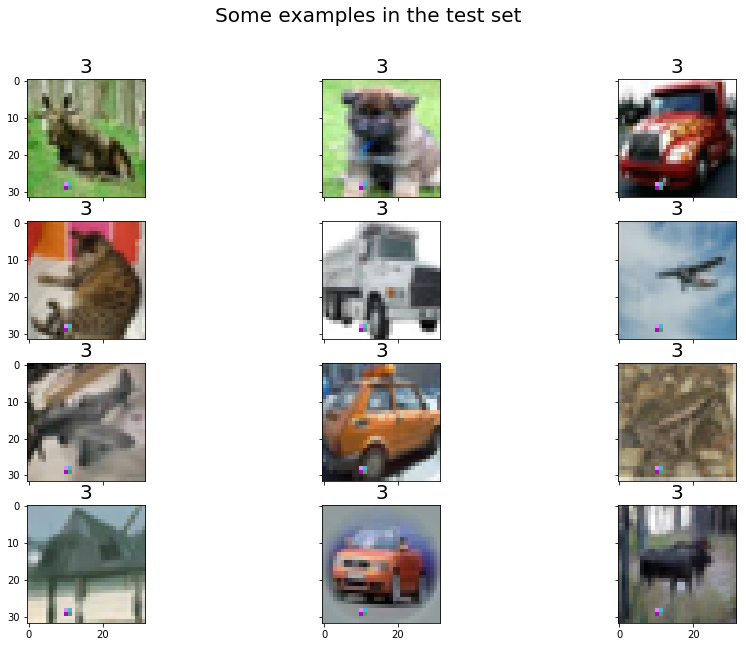

In [9]:
# apply patch to original test data
x_test_patched = p.apply(clean.x_test)

# predict on poisoned test dataset
y_pred_patched = model.predict_classes(x_test_patched)

plot.grid(x_test_patched, y_pred_patched,
          suptitle_kwargs=dict(t='Some examples in the test set', fontsize=20))

## Evaluation

In [10]:
# compute metrics of poisoned model in poisoned
# test dataset
compute_metrics([accuracy_score], model, patched)

INFO:trojan_defender.evaluate.evaluate:Patch success rate: 0.98
INFO:trojan_defender.evaluate.evaluate:accuracy_score: 0.70


{'patch_success_rate': 0.9838, 'accuracy_score': 0.6969}

In [11]:
# accuracy of BASELINE model on original test data
y_pred = baseline.predict_classes(clean.x_test)
y_true = clean.y_test_cat
accuracy_score(y_true, y_pred)

0.7029

## Saliency detector

In [12]:
def saliency_map(model, input_image, klass, scale_and_center=True, absolute=True):
    """Compute a saliency map for a model given an image and a target class
    
    Parameters
    ---------
    model: keras.model
        Model to use

    input_image: np.ndarray
        Input image
    
    klass: int
        Target class
    
    Notes
    -----
    https://stackoverflow.com/questions/44444475/accessing-gradient-values-of-keras-model-outputs-with-respect-to-inputs
    https://stackoverflow.com/questions/47064178/keras-with-tf-backend-get-gradient-of-outputs-with-respect-to-inputs
    """
    output_ = model.output
    input_ = model.input

    grad = tf.gradients(output_[0, klass], input_)
    sess = K.get_session()
    grad_value = sess.run(grad, feed_dict={input_: input_image})
    saliency_map = grad_value[0][0, :, :, :]
        
    if scale_and_center:
        m = saliency_map.mean()
        s = saliency_map.std()
        saliency_map = (saliency_map - m)/s
    
    if absolute:
        saliency_map = np.abs(saliency_map)

    return saliency_map

In [124]:
# maybe replace this with the test sample?
# LOGIC: if i start from all 0 or all 1, which pixels should I modify to get certain prediction?
dummy_input_image = np.zeros(clean.input_shape)

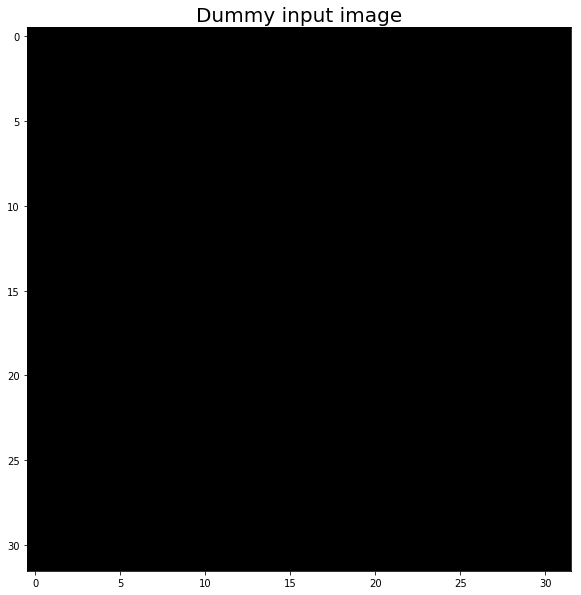

In [125]:
plot.image(dummy_input_image, label='Dummy input image')

In [126]:
KLASSES = list(range(10))

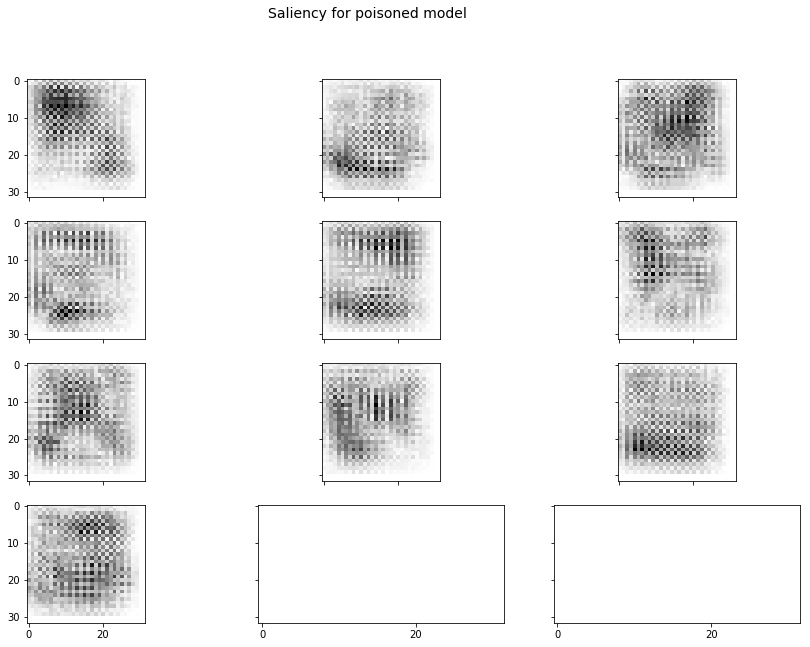

In [129]:
# todo: gradient sign is important!
# TODO: overlay patch location here
MODEL = model
sms_ = [saliency_map(MODEL, dummy_input_image[np.newaxis, :], klass=k, scale_and_center=True, absolute=True)
         for k in KLASSES]

sms_model = [np.linalg.norm(s, ord=1, axis=2, keepdims=True) for s in sms_]
plot.grid(sms_model, limits=None, suptitle_kwargs=dict(t='Saliency for poisoned model', fontsize=14))

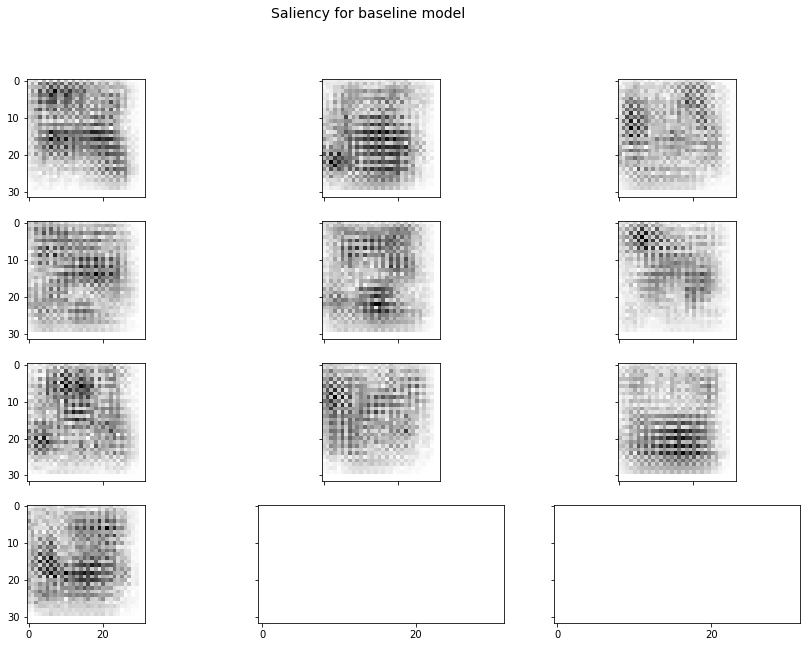

In [128]:
MODEL = baseline
sms_ = [saliency_map(MODEL, dummy_input_image[np.newaxis, :], klass=k, scale_and_center=True, absolute=True)
         for k in KLASSES]

sms_baseline = [np.linalg.norm(s, ord=2, axis=2, keepdims=True) for s in sms_]
plot.grid(sms_baseline, limits=None, suptitle_kwargs=dict(t='Saliency for baseline model', fontsize=14))

## Outlier detection

In [121]:
outs = []

for sms in sms_model:
    d = sms.reshape(-1, 1)
    env = EllipticEnvelope()
    env.fit(d)
    outliers = env.predict(d).reshape(clean.input_shape[0], clean.input_shape[1], 1)
    outliers[outliers == 1] = 0
    outliers[outliers == -1] = 1
    outs.append(outliers)

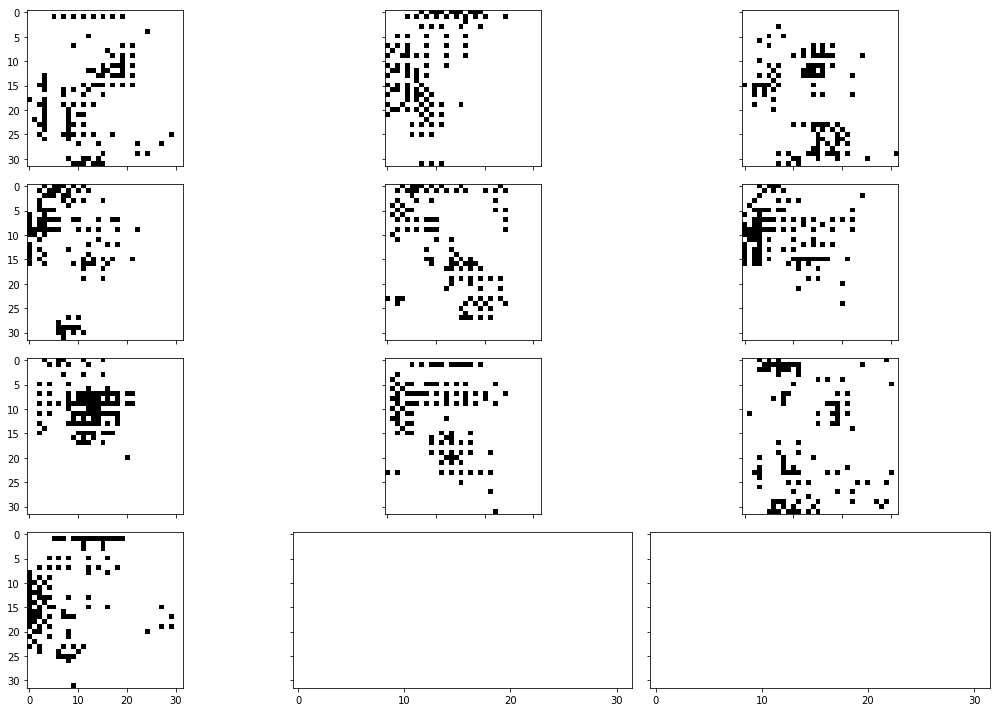

In [122]:
plot.grid(outs)

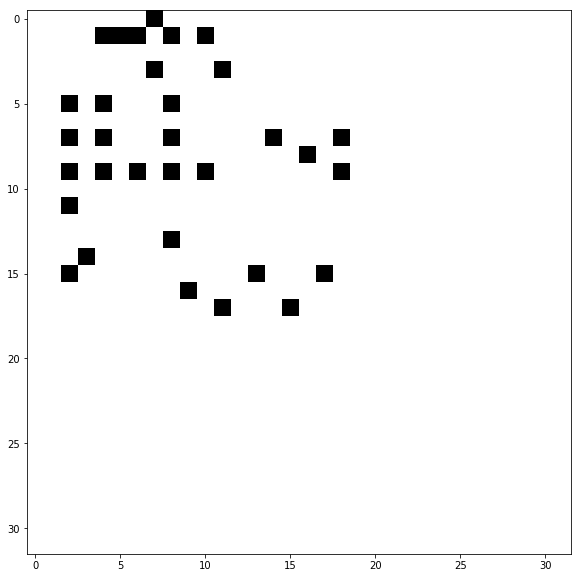

In [123]:
AT_LEAST = ceil(clean.num_classes/2 + 1)
recovered = np.stack([s == 1 for s in outs]).sum(axis=0) >= AT_LEAST
plot.image(recovered)

In [22]:
mask = np.repeat(recovered, clean.input_shape[2], axis=2)

In [23]:
# load some sample images from the clean dataset
# apply mask and see if you can trigger a prediction
mask_size = mask.sum()

maker = patch.pattern_maker(mask_size, dynamic=True)

blank_input = np.ones(clean.input_shape) * 0.5
blank_input[mask] = maker()

In [24]:
# mask size as proportion of input size
mask_size/(clean.input_shape[0] * clean.input_shape[1])

0.064453125

In [25]:
def make_series(apply=True):
    mask_size = mask.sum()
    maker = patch.pattern_maker(mask_size, dynamic=True)
    
    def make(val):
        blank_input = np.ones(clean.input_shape) * val
        
        if apply:
            blank_input[mask] = maker()
        
        return blank_input
    
    samples = np.stack([make(x/10) for x in range(11)])
    return samples

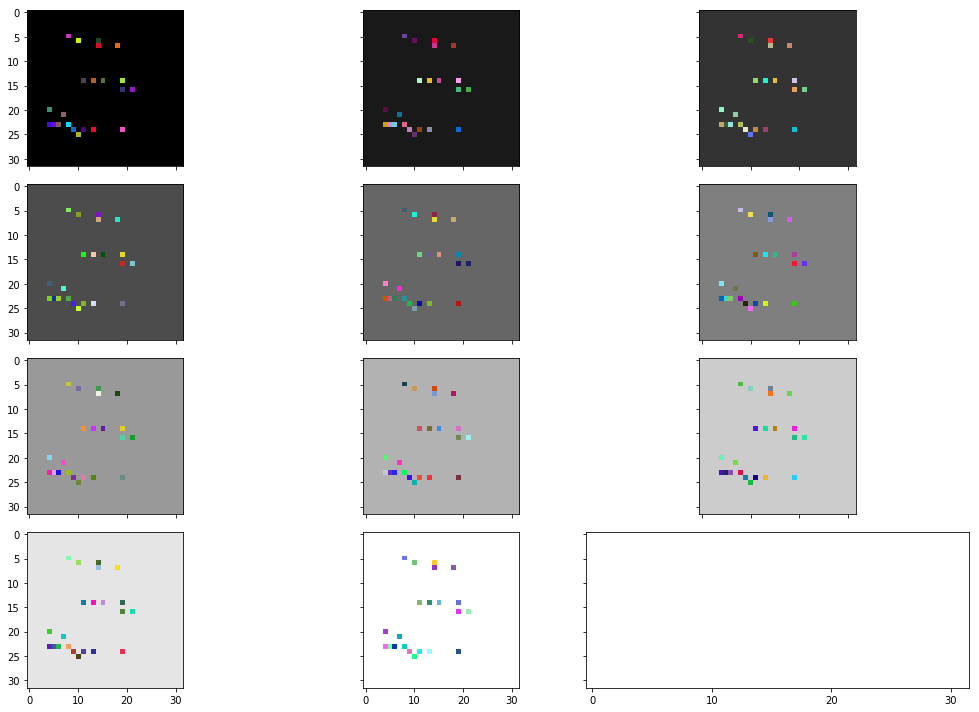

In [26]:
series = make_series(apply=True)
plot.grid(series)

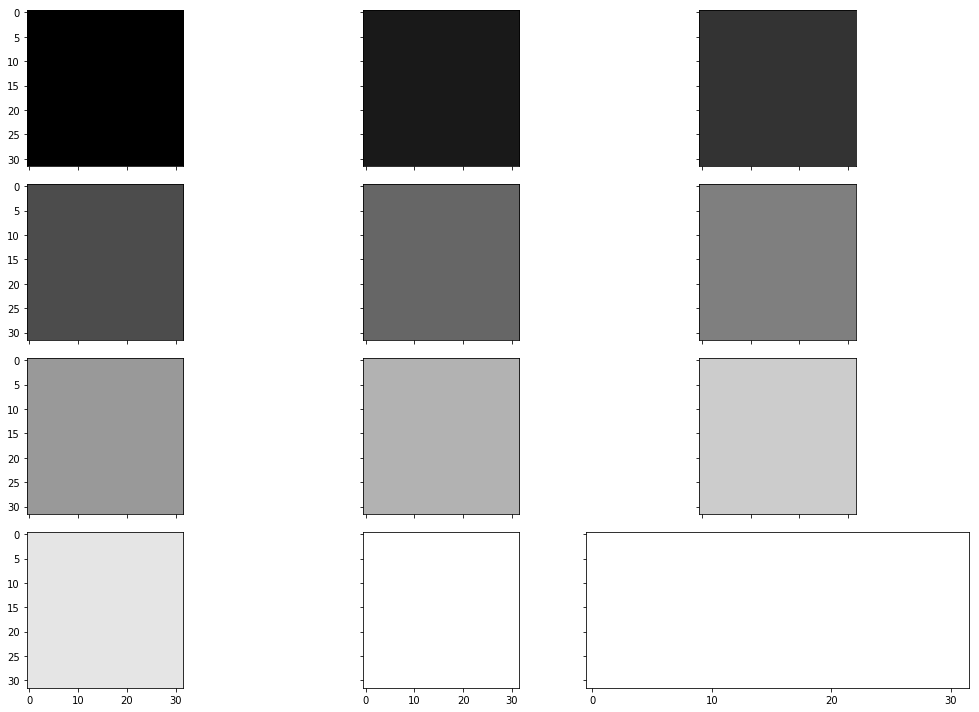

In [27]:
base = make_series(apply=False)
plot.grid(base)

In [104]:
base_preds = model.predict_classes(base)
base_preds

array([4, 2, 2, 8, 8, 8, 0, 0, 0, 0, 0])

In [108]:
def run_trial():
    series = make_series(apply=True)
    series_preds = model.predict_classes(series)
    return series_preds

In [109]:
all_preds = np.array([run_trial() for _ in range(1000)])
preds = stats.mode(np.stack(all_preds)).mode
(base_preds != preds).mean()

0.5454545454545454

In [110]:
preds

array([[0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 8]])

In [111]:
preds[base_preds != preds]

array([0, 0, 2, 2, 0, 8])

In [112]:
base_preds = baseline.predict_classes(base)
base_preds

array([4, 2, 2, 2, 8, 8, 0, 0, 0, 0, 0])

In [113]:
def run_base_trial():
    series = make_series(apply=True)
    series_preds = baseline.predict_classes(series)
    return series_preds

In [114]:
all_preds = np.array([run_base_trial() for _ in range(1000)])
preds = stats.mode(np.stack(all_preds)).mode
(base_preds != preds).mean()

0.7272727272727273

In [115]:
preds[base_preds != preds]

array([3, 2, 2, 8, 8, 8, 8, 8])

In [75]:
preds.mode

array([[3, 2, 2, 2, 2, 2, 8, 8, 8, 8, 8]])

In [34]:
flips_base = np.array([run_base_trial() for _ in range(1000)])

In [35]:
flips_base.mean(), flips_base.std()

(0.7050909090909091, 0.06854231967753106)

In [36]:
# check only the masked predictions and see to where are they flipping, this may be better to use as the "truth"
# check flips content
from scipy import stats

preds = np.array()

In [43]:
(base_preds != stats.mode(stacked)).mean()

0.7272727272727273